# Домашнее задание / Сверточные сети

В данном задании надо решить задачу классификации картинок с помощью VGG подобной сети, но не на CIFAR-10 который мы разбирали в классе, а на MNIST. Задача кажется проще той, которую мы рассматривали, поэтому модель надо не просто применить, а надо адаптировать. Так как задача сильно проще, модель надо уменьшить. Ожидаемая метрика качества - точность около 98% на тестовой выборке. Тот кто решит задачу с заданной точность и минимальным размером модели, получит дополнительные баллы.

In [ ]:
import sklearn
import numpy as np
from random import randrange
import time
from sklearn.model_selection import train_test_split

from keras import layers, models, optimizers, backend, metrics, callbacks
from keras.datasets import cifar10, mnist, imdb

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [3]:
# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


Визуализируем классы

In [4]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

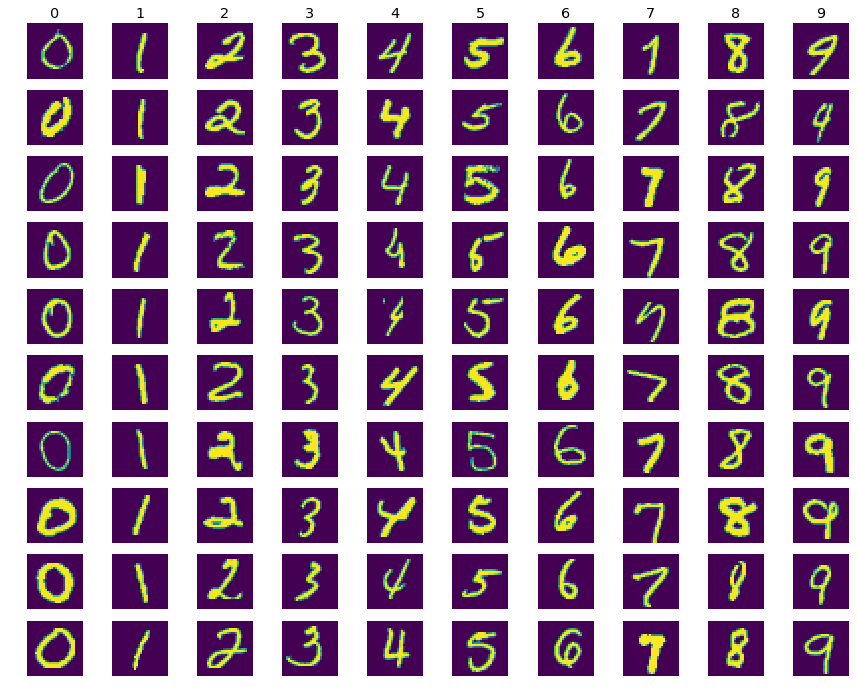

In [5]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Preprocessing: вычитаем среднее

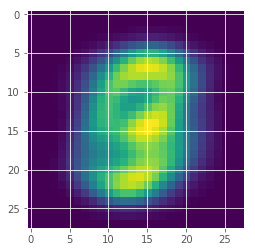

In [6]:
#1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [ ]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = (x_train - mean_image) / 255
x_test = (x_test - mean_image) / 255

Разделим тренировочную выборку на две части

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Для решения задачи реализуем топологию [VGG-16](https://arxiv.org/pdf/1409.1556.pdf)

![image.png](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)

### Опишем граф модели

#### Адаптируйте модель под новую задачу, пишите код для вашей модели в функции build_vgg16_mnist (она определена ниже)

In [ ]:
def build_vgg16():
    # Точка входа в граф задаётся при помощи специальных тензоров типа Input
    image_input = layers.Input(shape=(32,32,3))
    
    x = layers.Conv2D(64, (3, 3), activation='elu', padding='same', name='block1_conv1')(image_input)
    x = layers.Conv2D(64, (3, 3), activation='elu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='elu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='elu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3), activation='elu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='elu', name='fc1')(x)
    x = layers.Dense(4096, activation='elu', name='fc2')(x)
    output = layers.Dense(10, activation='softmax', name='predictions')(x)
    
    model = models.Model(inputs=image_input, outputs=output, name = 'vgg16')
    
    
    #  Для оптимизации будем использовать Adam 
    adam = optimizers.Adam(lr=0.0001)
    
    #Перед испльзованием модель необходимо скомпилировать
    model.compile(adam, 'sparse_categorical_crossentropy', metrics=['acc'])
    
    return model 

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [ ]:
# Перед созданием модели не забываем очищать сессию
backend.clear_session()
model = build_vgg16()

Keras позволяет выводить на экран удобное табличное описание графа модели

In [ ]:
model.summary()

-----

In [ ]:
def build_vgg16_mnist():
    
    # Код вашей модели
    
    return None 

In [ ]:
# Перед созданием модели не забываем очищать сессию
backend.clear_session()
model = build_vgg16_mnist()

In [ ]:
model.summary()

Во сколько раз уменьшился размер модели по сравнению с оригинальной?

### Теперь обучим модель. 
Приведённый ниже код будет аналогом тренировочного цикла из примера Tensorflow

In [ ]:
cbs = [
    callbacks.ModelCheckpoint('models/{epoch:02d}-{val_loss:.4f}.h5', save_best_only=True),
    callbacks.TensorBoard(log_dir='models'),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=0.00001, epsilon=0.01)]


model.fit(x=x_train, 
          y=y_train, 
          batch_size=128, 
          epochs=10, 
          callbacks=cbs,
          validation_data=(x_val, y_val))

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)

In [ ]:
print(f'accuracy: {accuracy:.2}')